In [109]:
# !wget --no-check-certificate \
#   http://download.tensorflow.org/example_images/flower_photos.tgz \
#   -O /tmp/flower_photos.zip
   

--2019-08-03 11:23:44--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.218.128, 2a00:1450:4013:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.218.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘/tmp/flower_photos.zip’

/tmp/flower_photos. 100%[===================>] 218.21M   114MB/s    in 1.9s    

2019-08-03 11:23:47 (114 MB/s) - ‘/tmp/flower_photos.zip’ saved [228813984/228813984]



In [110]:
# !wget https://www.graphicsfuel.com/wp-content/uploads/2012/02/free-flower-photos.zip -O flowers.zip

--2019-08-03 11:23:49--  https://www.graphicsfuel.com/wp-content/uploads/2012/02/free-flower-photos.zip
Resolving www.graphicsfuel.com (www.graphicsfuel.com)... 162.255.162.71
Connecting to www.graphicsfuel.com (www.graphicsfuel.com)|162.255.162.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7822981 (7.5M) [application/zip]
Saving to: ‘flowers.zip’

flowers.zip         100%[===================>]   7.46M  1.86MB/s    in 4.0s    

2019-08-03 11:23:54 (1.86 MB/s) - ‘flowers.zip’ saved [7822981/7822981]



In [0]:
# import cv2
# import glob
# import os
# import zipfile
# import tensorflow as tf
# import numpy as np
# import tarfile
# import matplotlib.image as mimg
# import matplotlib.pyplot as plt
# %matplotlib inline
os.mkdir('./color_images')
os.mkdir('./gray_images')
os.mkdir('./test_images')
os.mkdir('./gen_gray_img')

In [0]:
path = '/tmp/flower_photos.zip'
tar_f = tarfile.open(path)
tar_f.extractall('/tmp')
tar_f.close()

In [0]:
path = 'flowers.zip'
zip_f = zipfile.ZipFile(path,'r')
zip_f.extractall('./flowers')
zip_f.close()

In [0]:
flower_path = '/tmp/flower_photos/'
daisy = os.path.join(flower_path,'daisy/*.jpg')
dandelion = os.path.join(flower_path,'dandelion/*.jpg')
roses = os.path.join(flower_path,'roses/*.jpg')
sunflowers = os.path.join(flower_path,'sunflowers/*.jpg')
tulips = os.path.join(flower_path,'tulips/*.jpg')


In [0]:
path_flowers = [daisy, dandelion, roses, sunflowers, tulips]

In [0]:
#Travering Folders From given paths:
i=0
for path in path_flowers:
  for file in glob.glob(path):
    color_img = cv2.imread(file)
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    #resizing images
    color_img = cv2.resize(color_img,(150,150))
    gray_img = cv2.resize(gray_img,(150,150))
    
    cv2.imwrite("./color_images/Cimg"+str(i)+'.jpg',color_img)
    cv2.imwrite("./gray_images/Gimg"+str(i)+'.jpg',gray_img)
    
    i += 1
    

In [117]:
print(len(os.listdir('./color_images')))


3670


In [0]:
#Preparing Test Data
files = glob.glob('flowers/*.jpg')
i=0
for file in files:
  
  img = cv2.imread(file,0)
  img = cv2.resize(img,(150,150))
  cv2.imwrite('./test_images/test'+str(i)+".jpg",img)
  i+=1

**Building** **AutoEncoder**

In [126]:
#Preparing Dataset
size = 3670
dataset = []

for i in range(0,size):
  img = cv2.imread("./color_images/Cimg"+str(i)+'.jpg')
  dataset.append(np.array(img))

train_data = np.asarray(dataset)

dataset = []
for i in range(0,size):
  img = cv2.imread("./gray_images/Gimg"+str(i)+'.jpg',0)
  dataset.append(np.array(img))

test_data =  np.asarray(dataset)
print(test_data.shape) #Adding Extra Dimension
test_data = test_data[:,:,:,np.newaxis]
print(test_data.shape)  

(3670, 150, 150)
(3670, 150, 150, 1)


In [0]:
def AutoEncoder(inp):
    
    # Encoder
    output = tf.layers.conv2d(inp, 128, 2, activation = tf.nn.relu)
    output = tf.layers.max_pooling2d(output, 2, 2, padding = 'same')
    
    # Decoder
    #Resize images to size using nearest neighbor interpolation.
    output = tf.image.resize_nearest_neighbor(output, tf.constant([151, 151]))
    output = tf.layers.conv2d(output, 1, 2, activation = None)
    
    return output

In [0]:
#Using PlaceHolder as we need to put External Data
AutoEn_input = tf.placeholder(tf.float32,(None,150,150,3))
AutoEn_target = tf.placeholder(tf.float32,(None,150,150,1))

AutoEn_output = AutoEncoder(AutoEn_input)

learnRate = 0.001

#Loss Function
loss = tf.reduce_mean(tf.square(AutoEn_output-AutoEn_target))
Optimizer = tf.train.AdamOptimizer(learning_rate = learnRate).minimize(loss)


In [0]:
#Initializng Variables
init = tf.global_variables_initializer()

In [133]:
#Training Network
batch = 50
epoch = 50

saving_model = './AutoEncoderRGB2GRAY.ckpt'
SAVE = tf.train.Saver(max_to_keep=3)
img = train_data[0:batch]
out = test_data[0:batch]

#Total batches
num_img = 3670
batch_s = num_img//batch

#Initializing Session 
with tf.Session() as sess:
  sess.run(init)
  
  for e in range(epoch):
    batch_size = 0
    for batch in range(batch_s):
      _,c = sess.run([Optimizer,loss], feed_dict={AutoEn_input: img, 
                                                  AutoEn_target: out})
      #Printing
      img = train_data[batch_size:batch_size+50]
      out = test_data[batch_size:batch_size+50]
      batch_size+=50
    print("Epoch: {} - loss = {:.5f} ".format((e+1),c))    
      
  SAVE.save(sess, saving_model, global_step=e)    
      

Epoch: 1 - loss = 251.01529 
Epoch: 2 - loss = 184.09908 
Epoch: 3 - loss = 173.46645 
Epoch: 4 - loss = 167.98050 
Epoch: 5 - loss = 164.33691 
Epoch: 6 - loss = 161.04469 
Epoch: 7 - loss = 158.01823 
Epoch: 8 - loss = 155.59564 
Epoch: 9 - loss = 153.36566 
Epoch: 10 - loss = 151.73262 
Epoch: 11 - loss = 150.51643 
Epoch: 12 - loss = 149.55040 
Epoch: 13 - loss = 148.97601 
Epoch: 14 - loss = 148.36345 
Epoch: 15 - loss = 148.07999 
Epoch: 16 - loss = 147.82385 
Epoch: 17 - loss = 147.42793 
Epoch: 18 - loss = 147.27705 
Epoch: 19 - loss = 147.25229 
Epoch: 20 - loss = 147.01096 
Epoch: 21 - loss = 146.87999 
Epoch: 22 - loss = 146.72636 
Epoch: 23 - loss = 146.88896 
Epoch: 24 - loss = 146.42313 
Epoch: 25 - loss = 146.65247 
Epoch: 26 - loss = 146.05292 
Epoch: 27 - loss = 146.23375 
Epoch: 28 - loss = 146.05417 
Epoch: 29 - loss = 145.81990 
Epoch: 30 - loss = 145.77924 
Epoch: 31 - loss = 145.59152 
Epoch: 32 - loss = 145.46439 
Epoch: 33 - loss = 145.40479 
Epoch: 34 - loss = 

In [161]:

#Testing
saver = tf.train.Saver()
with tf.Session() as sess:
  sess.run(init)
  saver.restore(sess,'./AutoEncoderRGB2GRAY.ckpt-49')
  
  files = glob.glob('flowers/*.jpg')
#   og = cv2.imread(files[0])
  test_d = []
  for file in files:
    img = cv2.imread(file)
    img = cv2.resize(img,(150,150))
    test_d.append(np.array(img))
  
  test = np.asarray(test_d)
  print(test.shape)
  #Running Test For AutoEncoder
  batch_imgs = test
  gray_imgs = sess.run(AutoEn_output,feed_dict={AutoEn_input: batch_imgs})
  
  for i in range (gray_imgs.shape[0]):
    cv2.imwrite('gen_gray_img/gen_gray'+str(i)+'.jpg',gray_imgs[i])
    

(5, 150, 150, 3)


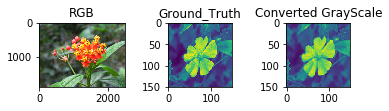

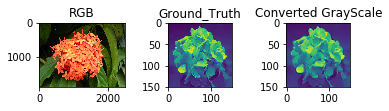

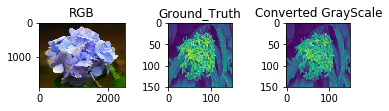

In [186]:
#Plotting Output
gen_img = glob.glob('./gen_gray_img/*.jpg')
true_img = glob.glob('./test_images/*.jpg')
rgb_img = glob.glob('./flowers/*.jpg')

for i in range(0,3):
  fig = plt.figure()
#   fig.suptitle("RGB      GroundTruth    Converted",size=16)
  ax1 = fig.add_subplot(3,3,1)
  ax1.set_title("RGB")
  img1 = mimg.imread(rgb_img[i])
  ax1.imshow(img1)
  ax2 = fig.add_subplot(3,3,2)
  ax2.set_title("Ground_Truth")
  img2 = mimg.imread(true_img[i])
  ax2.imshow(img2)
  ax3 = fig.add_subplot(3,3,3)
  ax3.set_title("Converted GrayScale")
  img3 = mimg.imread(gen_img[i])
  ax3.imshow(img3)

In [194]:
pip install pipreqs